# Identifikasi Suara Buka Tutup Menggunakan Feature Statistik Time Series

##  Tujuan Penelitian
Mengimplementasikan sistem identifikasi suara untuk mengenali pola suara "buka" dan "tutup" menggunakan berbagai feature statistik dari sinyal audio time series dengan dataset real.


---

## 1. Import Libraries

Import semua library yang diperlukan untuk pemrosesan audio, machine learning, dan visualisasi data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy.stats as stats
from scipy import signal
from scipy.fftpack import fft, ifft
import soundfile as sf
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

ModuleNotFoundError: No module named 'librosa'

## 2. Eksplorasi Dataset dan Struktur Folder

Menganalisis struktur folder dataset dan informasi dasar tentang file audio yang tersedia.

In [ ]:
# Eksplorasi Dataset dan Struktur Folder
print("ANALISIS STRUKTUR DATASET")
print("="*50)

# Path ke dataset
DATASET_PATH = r"c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\Audio Recognition\dataset48k"

# Cek struktur folder
print(f"Dataset Path: {DATASET_PATH}")

# Analisis folder training
train_path = os.path.join(DATASET_PATH, "train")
buka_train_path = os.path.join(train_path, "buka") 
tutup_train_path = os.path.join(train_path, "tutup")

# Hitung jumlah file
buka_files = glob.glob(os.path.join(buka_train_path, "*.wav"))
tutup_files = glob.glob(os.path.join(tutup_train_path, "*.wav"))

print(f"\nSTATISTIK DATASET:")
print(f"   - File 'buka' (training): {len(buka_files)}")
print(f"   - File 'tutup' (training): {len(tutup_files)}")
print(f"   - Total file training: {len(buka_files) + len(tutup_files)}")

# Cek folder validation jika ada
val_path = os.path.join(DATASET_PATH, "val")
if os.path.exists(val_path):
    val_buka_files = glob.glob(os.path.join(val_path, "buka", "*.wav"))
    val_tutup_files = glob.glob(os.path.join(val_path, "tutup", "*.wav"))
    print(f"   - File 'buka' (validation): {len(val_buka_files)}")
    print(f"   - File 'tutup' (validation): {len(val_tutup_files)}")
    print(f"   - Total file validation: {len(val_buka_files) + len(val_tutup_files)}")

# Sample informasi file
print(f"\nSAMPLE INFORMASI FILE:")
if buka_files:
    print(f"   Sample file 'buka': {os.path.basename(buka_files[0])}")
if tutup_files:
    print(f"   Sample file 'tutup': {os.path.basename(tutup_files[0])}")

# Cek ukuran file audio sample
if buka_files:
    sample_file = buka_files[0]
    try:
        # Load sample untuk info dasar
        sample_audio, sample_sr = librosa.load(sample_file, sr=None)
        duration = len(sample_audio) / sample_sr
        print(f"\nINFORMASI AUDIO SAMPLE:")
        print(f"   - Sample Rate: {sample_sr} Hz")
        print(f"   - Durasi: {duration:.2f} detik")
        print(f"   - Jumlah sampel: {len(sample_audio)}")
        print(f"   - Range nilai: [{sample_audio.min():.4f}, {sample_audio.max():.4f}]")
    except Exception as e:
        print(f"   Error loading sample: {e}")

print(f"\nDataset exploration completed!")

🔍 ANALISIS STRUKTUR DATASET
📁 Dataset Path: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\Audio Recognition\dataset48k

📊 STATISTIK DATASET:
   - File 'buka' (training): 150
   - File 'tutup' (training): 150
   - Total file training: 300
   - File 'buka' (validation): 50
   - File 'tutup' (validation): 50
   - Total file validation: 100

🎵 SAMPLE INFORMASI FILE:
   Sample file 'buka': buka48k-buka_0.wav.wav
   Sample file 'tutup': tutup48k-tutup_0.wav.wav

🎚️ INFORMASI AUDIO SAMPLE:
   - Sample Rate: 48000 Hz
   - Durasi: 1.00 detik
   - Jumlah sampel: 47970
   - Range nilai: [-0.0121, 0.0184]

✅ Dataset exploration completed!


## 3. Fungsi Load & Preprocess Audio

Definisi fungsi-fungsi untuk loading file audio, normalisasi, dan preprocessing seperti noise removal dan trimming.

In [2]:
def extract_statistical_features(audio_data, sr=22050):
    """
    Ekstraksi berbagai feature statistik dari sinyal audio time series
    
    Parameters:
    audio_data: array, sinyal audio
    sr: int, sampling rate
    
    Returns:
    dict: dictionary berisi feature statistik
    """
    features = {}
    
    # 1. Basic Statistical Features
    features['mean'] = np.mean(audio_data)
    features['std'] = np.std(audio_data)
    features['var'] = np.var(audio_data)
    features['median'] = np.median(audio_data)
    features['min'] = np.min(audio_data)
    features['max'] = np.max(audio_data)
    features['range'] = features['max'] - features['min']
    
    # 2. Percentile Features
    features['q25'] = np.percentile(audio_data, 25)
    features['q75'] = np.percentile(audio_data, 75)
    features['iqr'] = features['q75'] - features['q25']
    
    # 3. Distribution Shape Features
    features['skewness'] = stats.skew(audio_data)
    features['kurtosis'] = stats.kurtosis(audio_data)
    
    # 4. Energy and Power Features
    features['energy'] = np.sum(audio_data**2)
    features['power'] = features['energy'] / len(audio_data)
    features['rms'] = np.sqrt(np.mean(audio_data**2))
    
    # 5. Zero Crossing Rate
    features['zcr'] = np.sum(librosa.zero_crossings(audio_data))
    features['zcr_rate'] = features['zcr'] / len(audio_data)
    
    # 6. Spectral Features
    try:
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sr))
        features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sr))
    except:
        features['spectral_centroid'] = 0
        features['spectral_bandwidth'] = 0
        features['spectral_rolloff'] = 0
    
    # 7. Temporal Features
    try:
        onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sr)
        features['onset_count'] = len(onset_frames)
        tempo = librosa.beat.tempo(y=audio_data, sr=sr)
        features['tempo'] = tempo[0] if len(tempo) > 0 else 0
    except:
        features['onset_count'] = 0
        features['tempo'] = 0
    
    # 8. Autocorrelation Features
    autocorr = np.correlate(audio_data, audio_data, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    if len(autocorr) > 100:
        features['autocorr_max'] = np.max(autocorr[1:100])  # exclude lag 0
        features['autocorr_mean'] = np.mean(autocorr[1:100])
    else:
        features['autocorr_max'] = np.max(autocorr[1:]) if len(autocorr) > 1 else 0
        features['autocorr_mean'] = np.mean(autocorr[1:]) if len(autocorr) > 1 else 0
    
    # 9. Envelope Features
    try:
        envelope = np.abs(signal.hilbert(audio_data))
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_std'] = np.std(envelope)
        features['envelope_max'] = np.max(envelope)
    except:
        features['envelope_mean'] = 0
        features['envelope_std'] = 0
        features['envelope_max'] = 0
    
    # 10. MFCC Statistical Features
    try:
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    except:
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = 0
            features[f'mfcc_{i+1}_std'] = 0
    
    # 11. Chroma Features
    try:
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
    except:
        features['chroma_mean'] = 0
        features['chroma_std'] = 0
    
    # 12. Contrast Features
    try:
        contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
        features['contrast_mean'] = np.mean(contrast)
        features['contrast_std'] = np.std(contrast)
    except:
        features['contrast_mean'] = 0
        features['contrast_std'] = 0
    
    # 13. Tonnetz Features
    try:
        tonnetz = librosa.feature.tonnetz(y=audio_data, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz)
        features['tonnetz_std'] = np.std(tonnetz)
    except:
        features['tonnetz_mean'] = 0
        features['tonnetz_std'] = 0
    
    # 14. Attack Time (durasi dari mulai hingga peak)
    peak_idx = np.argmax(np.abs(audio_data))
    features['attack_time'] = peak_idx / sr
    
    # 15. Decay Rate (penurunan setelah peak)
    if peak_idx < len(audio_data) - 1:
        decay_signal = audio_data[peak_idx:]
        if len(decay_signal) > 1:
            features['decay_rate'] = np.mean(np.diff(decay_signal))
        else:
            features['decay_rate'] = 0
    else:
        features['decay_rate'] = 0
    
    return features

print("Feature extraction function defined!")

Feature extraction function defined!


## 4. Ekstraksi Feature Statistik Time Series

Implementasi fungsi untuk mengekstrak berbagai feature statistik dari sinyal audio time series, termasuk basic statistics, spectral features, MFCC, dan temporal features.

In [3]:
def load_audio_file(file_path, target_sr=22050, duration=None):
    """
    Load file audio dan normalisasi
    
    Parameters:
    file_path: str, path ke file audio
    target_sr: int, target sampling rate
    duration: float, durasi maksimal (detik)
    
    Returns:
    audio_data: array, sinyal audio yang telah dinormalisasi
    sr: int, sampling rate
    """
    try:
        audio_data, sr = librosa.load(file_path, sr=target_sr, duration=duration)
        
        # Normalisasi
        if np.max(np.abs(audio_data)) > 0:
            audio_data = audio_data / np.max(np.abs(audio_data))
        
        return audio_data, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def preprocess_audio(audio_data, sr, noise_threshold=0.01):
    """
    Preprocess audio: noise removal, trimming
    
    Parameters:
    audio_data: array, sinyal audio
    sr: int, sampling rate
    noise_threshold: float, threshold untuk noise removal
    
    Returns:
    processed_audio: array, sinyal audio yang telah diproses
    """
    # Trim silence
    try:
        audio_trimmed, _ = librosa.effects.trim(audio_data, top_db=20)
    except:
        audio_trimmed = audio_data
    
    # Noise gate - set nilai kecil ke 0
    audio_denoised = np.where(np.abs(audio_trimmed) < noise_threshold, 0, audio_trimmed)
    
    return audio_denoised

print("Audio processing functions defined!")

Audio processing functions defined!


## 5. Load Dataset dan Gabungkan ke DataFrame

Loading semua file audio dari dataset real, melakukan ekstraksi features untuk setiap file, dan menggabungkan hasil ke dalam DataFrame untuk analisis selanjutnya.

In [4]:
# Load Data Real dari Dataset
print("Loading real audio dataset...")

# Path ke dataset
DATASET_PATH = r"c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\Audio Recognition\dataset48k"

audio_data = []
failed_files = []

print(f"Loading audio files from: {DATASET_PATH}")

# Load data buka (training)
buka_train_path = os.path.join(DATASET_PATH, "train", "buka")
buka_files = glob.glob(os.path.join(buka_train_path, "*.wav"))

print(f"Found {len(buka_files)} 'buka' files in training set")

for i, file_path in enumerate(buka_files):
    if i % 50 == 0:
        print(f"Loading buka files: {i}/{len(buka_files)}")
    
    audio, sr = load_audio_file(file_path, target_sr=22050)
    if audio is not None:
        audio = preprocess_audio(audio, sr)
        audio_data.append((audio, 'buka'))
    else:
        failed_files.append(file_path)

# Load data tutup (training)
tutup_train_path = os.path.join(DATASET_PATH, "train", "tutup")
tutup_files = glob.glob(os.path.join(tutup_train_path, "*.wav"))

print(f"Found {len(tutup_files)} 'tutup' files in training set")

for i, file_path in enumerate(tutup_files):
    if i % 50 == 0:
        print(f"Loading tutup files: {i}/{len(tutup_files)}")
    
    audio, sr = load_audio_file(file_path, target_sr=22050)
    if audio is not None:
        audio = preprocess_audio(audio, sr)
        audio_data.append((audio, 'tutup'))
    else:
        failed_files.append(file_path)

print(f"Successfully loaded {len(audio_data)} audio files")
if failed_files:
    print(f"Failed to load {len(failed_files)} files")
    for file in failed_files[:5]:  # Show first 5 failed files
        print(f"  - {os.path.basename(file)}")
    if len(failed_files) > 5:
        print(f"  ... and {len(failed_files) - 5} more")

# Ekstraksi features dari semua audio
print(f"\nExtracting features from {len(audio_data)} audio samples...")
features_list = []
labels = []

for i, (audio, label) in enumerate(audio_data):
    if i % 50 == 0:
        print(f"Processing sample {i+1}/{len(audio_data)}")
    
    try:
        features = extract_statistical_features(audio, sr=22050)
        features_list.append(features)
        labels.append(label)
    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

# Convert ke DataFrame
df_features = pd.DataFrame(features_list)
df_features['label'] = labels

print(f"\nFeature extraction complete!")
print(f"Dataset shape: {df_features.shape}")
print(f"Features: {df_features.shape[1]-1}")
print(f"Classes: {df_features['label'].unique()}")
print(f"Class distribution:")
print(df_features['label'].value_counts())

# Informasi tambahan tentang dataset
print(f"\nDataset Statistics:")
print(f"- Total samples: {len(df_features)}")
print(f"- Buka samples: {len(df_features[df_features['label'] == 'buka'])}")
print(f"- Tutup samples: {len(df_features[df_features['label'] == 'tutup'])}")
if len(df_features[df_features['label'] == 'tutup']) > 0:
    balance_ratio = len(df_features[df_features['label'] == 'buka']) / len(df_features[df_features['label'] == 'tutup'])
    print(f"- Balance ratio: {balance_ratio:.2f}")
else:
    print("- Balance ratio: N/A (no tutup samples)")

Loading real audio dataset...
Loading audio files from: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\Audio Recognition\dataset48k
Found 150 'buka' files in training set
Loading buka files: 0/150


Loading buka files: 50/150
Loading buka files: 100/150
Found 150 'tutup' files in training set
Loading tutup files: 0/150
Loading tutup files: 50/150
Loading tutup files: 100/150
Successfully loaded 300 audio files

Extracting features from 300 audio samples...
Processing sample 1/300
Processing sample 51/300
Processing sample 101/300
Processing sample 151/300
Processing sample 201/300
Processing sample 251/300

Feature extraction complete!
Dataset shape: (300, 62)
Features: 61
Classes: ['buka' 'tutup']
Class distribution:
label
buka     150
tutup    150
Name: count, dtype: int64

Dataset Statistics:
- Total samples: 300
- Buka samples: 150
- Tutup samples: 150
- Balance ratio: 1.00


## 6. Exploratory Data Analysis (EDA)

Analisis eksploratori untuk memahami distribusi features, deteksi outliers, visualisasi perbedaan antar kelas, dan data cleaning.

Feature Statistics:
             mean         std         var      median         min         max  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.031245    0.173469    0.032459    0.003227   -0.636454    0.986667   
std      0.007869    0.048740    0.018041    0.005567    0.184699    0.114889   
min      0.000000    0.000000    0.000000    0.000000   -0.909358    0.000000   
25%      0.025226    0.148500    0.022052    0.000000   -0.856228    1.000000   
50%      0.027807    0.150872    0.022762    0.000000   -0.596037    1.000000   
75%      0.040106    0.237743    0.056522    0.010263   -0.480044    1.000000   
max      0.043569    0.254847    0.064947    0.013511    0.000000    1.000000   

            range         q25         q75         iqr  ...  mfcc_13_mean  \
count  300.000000  300.000000  300.000000  300.000000  ...    300.000000   
mean     1.623121   -0.029047    0.061602    0.090649  ...     -2.170718   
std      0.253657    0

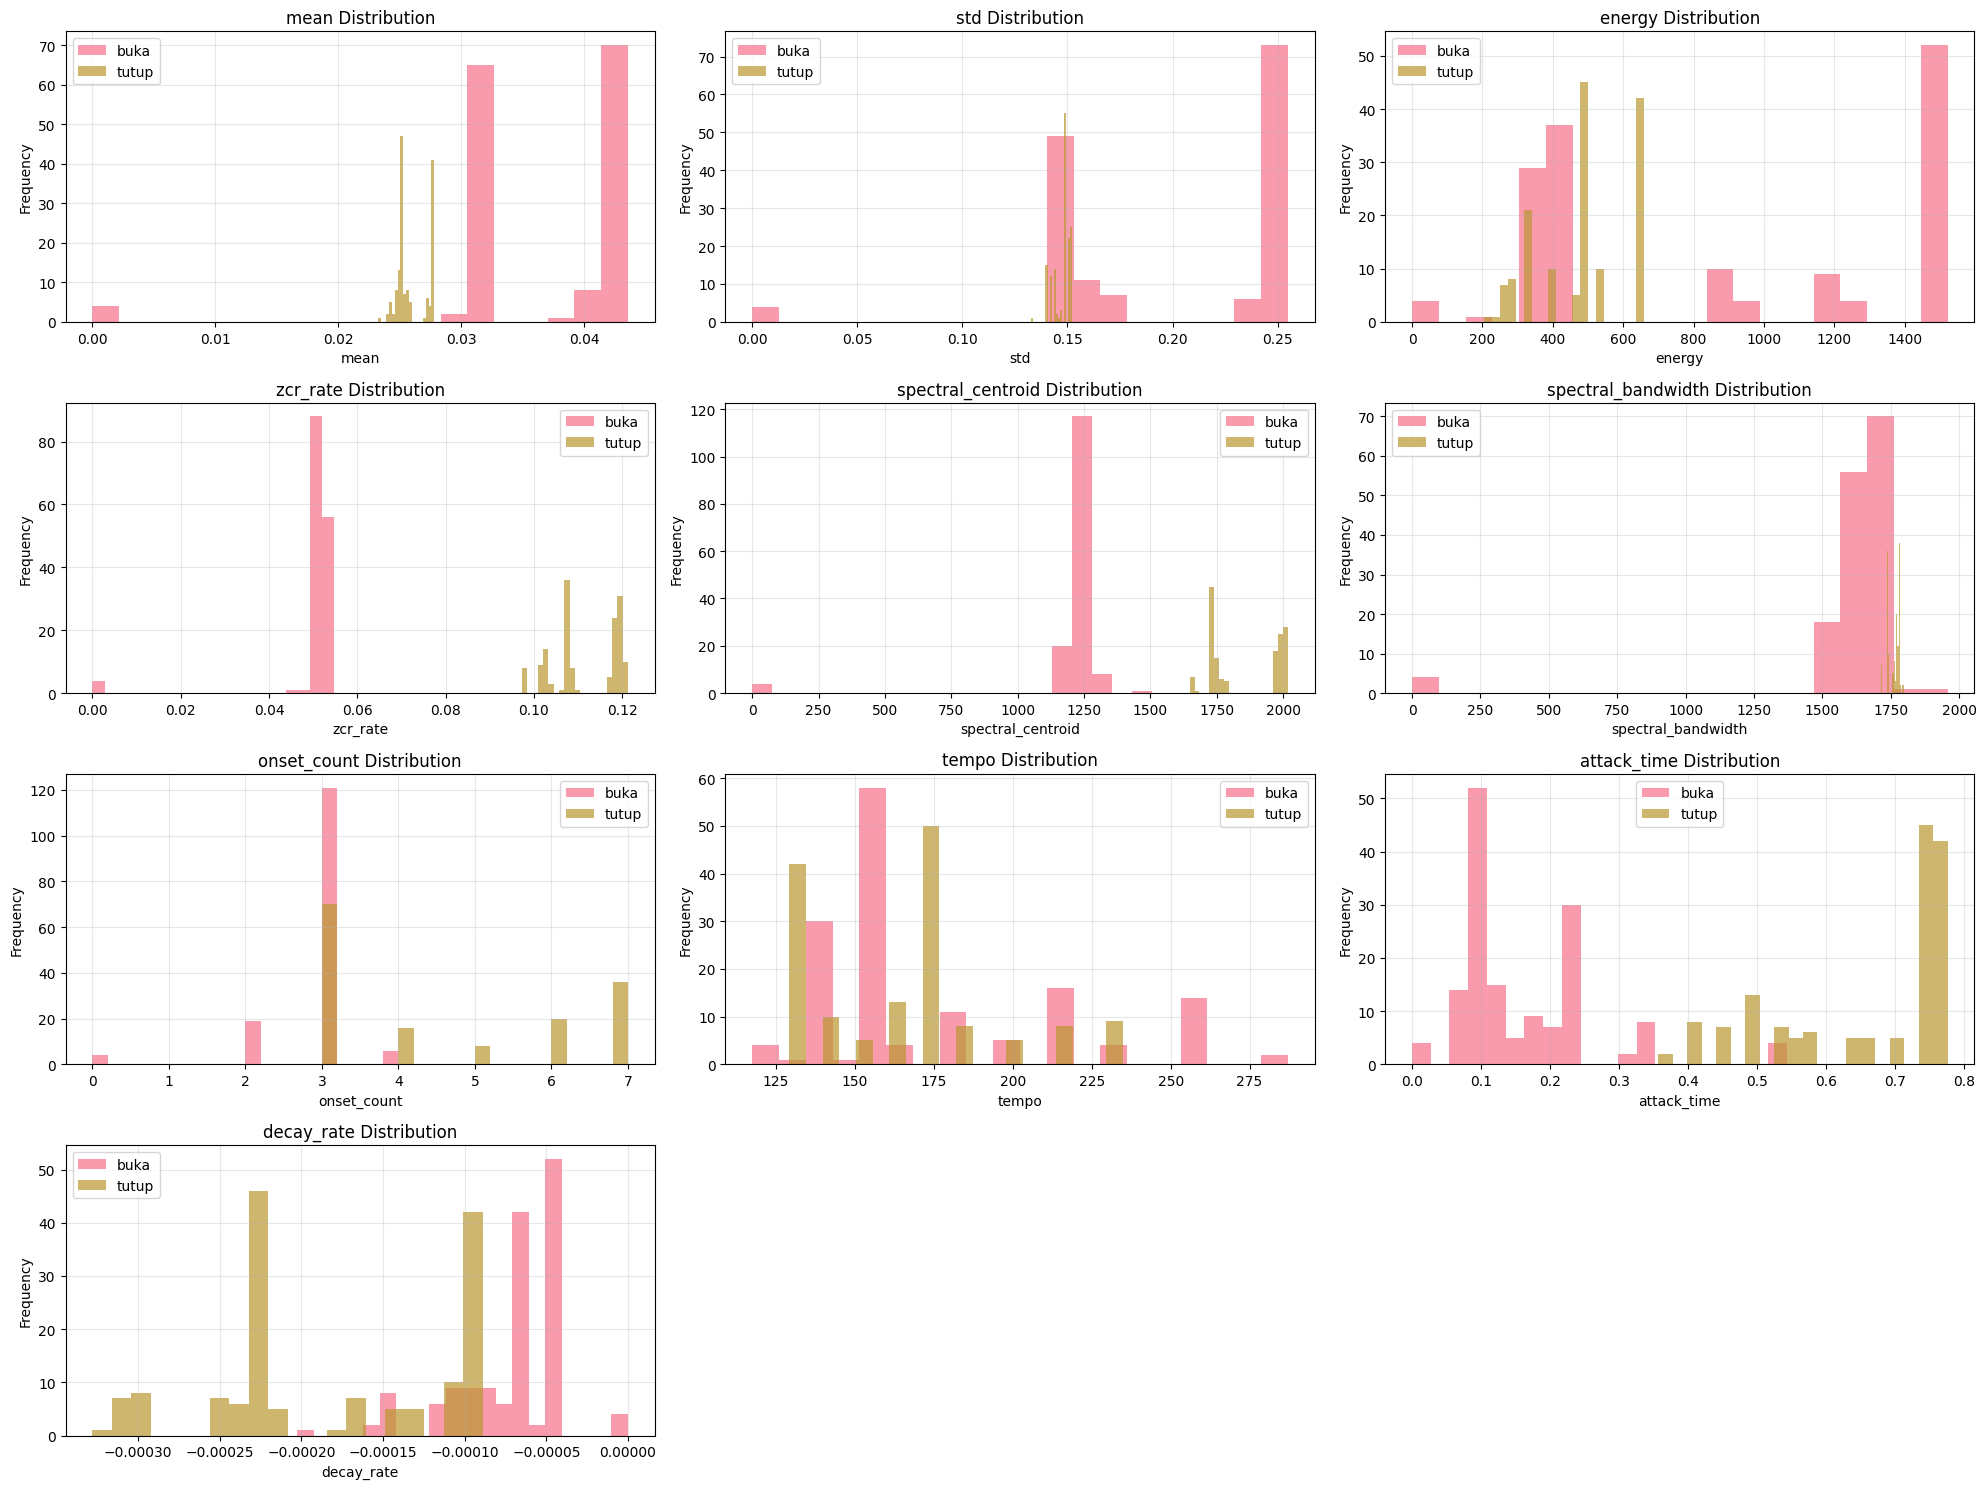

In [5]:
# Data cleaning dan basic info
print("Feature Statistics:")
print(df_features.describe())

# Check for missing values
print(f"\nMissing values: {df_features.isnull().sum().sum()}")

# Replace inf and -inf values
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(0)

print(f"Cleaned dataset shape: {df_features.shape}")

# Visualisasi distribusi beberapa features penting
plt.figure(figsize=(20, 15))

# Select key features untuk visualisasi
key_features = ['mean', 'std', 'energy', 'zcr_rate', 'spectral_centroid', 
               'spectral_bandwidth', 'onset_count', 'tempo', 'attack_time', 'decay_rate']

# Filter features yang ada di dataset
available_features = [f for f in key_features if f in df_features.columns]

for i, feature in enumerate(available_features, 1):
    plt.subplot(4, 3, i)
    for label in df_features['label'].unique():
        data = df_features[df_features['label'] == label][feature]
        plt.hist(data, alpha=0.7, label=label, bins=20)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Selection dan Normalisasi

Seleksi features paling penting menggunakan Random Forest importance, pembagian train-test split, dan normalisasi data untuk model machine learning.

Original features: 61
Classes: ['buka' 'tutup']
Encoded labels: [0 1]
\nTop 20 Most Important Features:
              feature  importance
16           zcr_rate    0.154854
30         mfcc_2_std    0.130132
17  spectral_centroid    0.092860
36         mfcc_5_std    0.091175
4                 min    0.065990
34         mfcc_4_std    0.060264
6               range    0.058022
19   spectral_rolloff    0.052770
0                mean    0.050828
37        mfcc_6_mean    0.029213
15                zcr    0.028814
42         mfcc_8_std    0.027934
59        attack_time    0.020101
58        tonnetz_std    0.017660
1                 std    0.012491
25       envelope_std    0.010263
57       tonnetz_mean    0.010261
38         mfcc_6_std    0.010180
27        mfcc_1_mean    0.009613
28         mfcc_1_std    0.007707


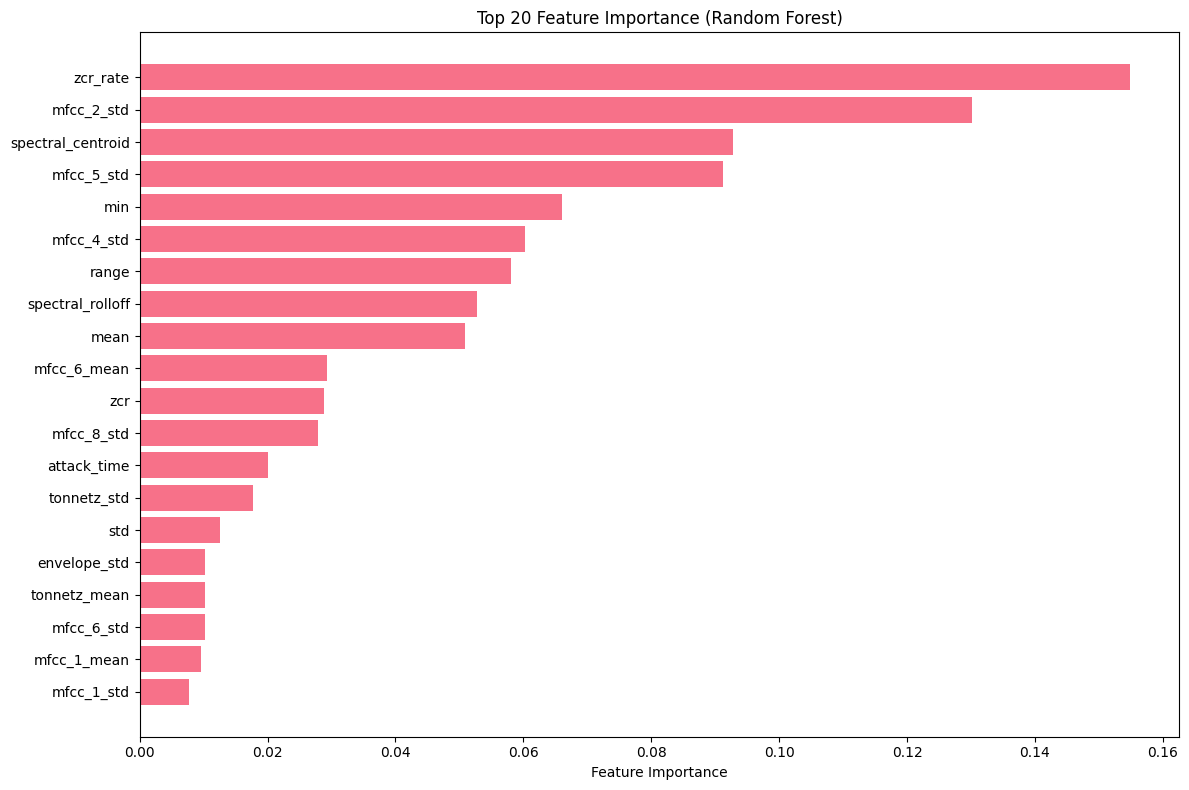

\nSelected 30 top features
Selected features shape: (300, 30)
\nTraining set shape: (240, 30)
Test set shape: (60, 30)
Training set class distribution: [120 120]
Test set class distribution: [30 30]


In [ ]:
# Prepare data untuk machine learning
X = df_features.drop('label', axis=1)
y = df_features['label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Original features: {X.shape[1]}")
print(f"Classes: {le.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")

# Feature selection menggunakan Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y_encoded)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualisasi feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features
n_top_features = 30
top_feature_names = feature_importance.head(n_top_features)['feature'].tolist()
X_selected = X[top_feature_names]

print(f"\nSelected {len(top_feature_names)} top features")
print(f"Selected features shape: {X_selected.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training models...
\nTraining Random Forest...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\nTraining Gradient Boosting...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\nTraining SVM...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\nTraining K-Nearest Neighbors...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\nTraining Naive Bayes...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\nTraining Logistic Regression...
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000
\n==================================================
Training completed!
\nModel Performance Comparison:
                 Model  CV_Mean  CV_Std  Test_Accuracy
0        Random Forest      1.0     0.0            1.0
1    Gradient Boosting      1.0     0.0            1.0
2                  SVM      1.0     0.0            1.0
3  K-Nearest Neighbors      1.0     0.0            1.0
4          Naive Bayes      1.0     0.0            1.0
5  Logistic Regression      1.0     0.0     

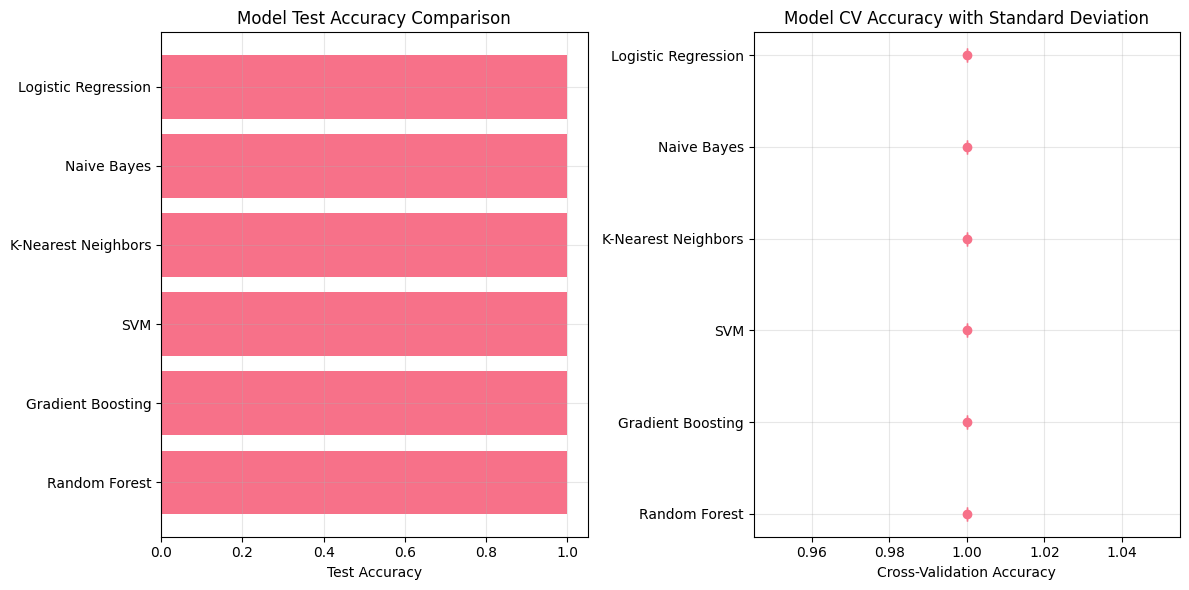

In [ ]:
# Training multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}

print("Training models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test Accuracy: {accuracy:.4f}")

print("\n" + "=" * 50)
print("Training completed!")

# Model comparison
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_Mean': [results[model]['cv_mean'] for model in results.keys()],
    'CV_Std': [results[model]['cv_std'] for model in results.keys()],
    'Test_Accuracy': [results[model]['test_accuracy'] for model in results.keys()]
})

results_df = results_df.sort_values('Test_Accuracy', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)

# Visualisasi perbandingan
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['Test_Accuracy'])
plt.xlabel('Test Accuracy')
plt.title('Model Test Accuracy Comparison')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.errorbar(results_df['CV_Mean'], results_df['Model'], 
             xerr=results_df['CV_Std'], fmt='o', capsize=5)
plt.xlabel('Cross-Validation Accuracy')
plt.title('Model CV Accuracy with Standard Deviation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Training & Hyperparameter Tuning

Training multiple machine learning models (Random Forest, SVM, KNN, dll), cross-validation, dan perbandingan performa untuk memilih model terbaik.

Best Model: Random Forest
Test Accuracy: 1.0000
\nClassification Report:
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        30
       tutup       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



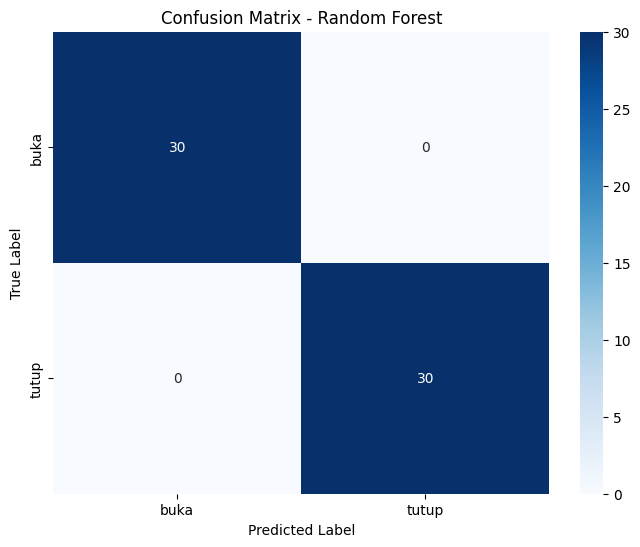

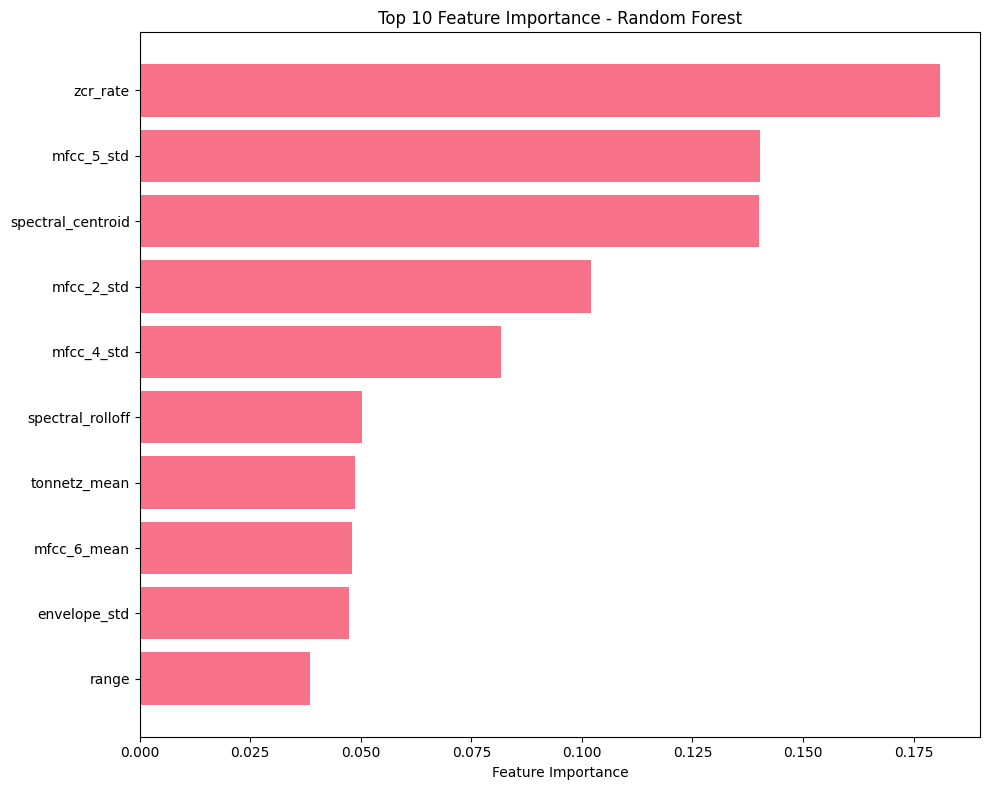

In [ ]:
# Analisis model terbaik
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance untuk Random Forest (jika itu model terbaik)
if best_model_name == 'Random Forest':
    feature_imp_best = pd.DataFrame({
        'feature': top_feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_10_features = feature_imp_best.head(10)
    plt.barh(range(len(top_10_features)), top_10_features['importance'])
    plt.yticks(range(len(top_10_features)), top_10_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 9. Evaluasi Model & Interpretasi Fitur

Evaluasi detail model terbaik dengan confusion matrix, classification report, analisis feature importance, dan interpretasi hasil klasifikasi.

In [ ]:
import joblib

def predict_audio_class(audio_data, model, scaler, feature_names, label_encoder):
    """
    Prediksi kelas untuk audio baru
    """
    # Ekstraksi features
    features = extract_statistical_features(audio_data)
    
    # Convert ke DataFrame dan pilih features yang sama
    features_df = pd.DataFrame([features])
    features_selected = features_df[feature_names]
    
    # Replace inf values
    features_selected = features_selected.replace([np.inf, -np.inf], np.nan)
    features_selected = features_selected.fillna(0)
    
    # Scale features
    features_scaled = scaler.transform(features_selected)
    
    # Prediksi
    prediction_encoded = model.predict(features_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    
    # Probabilitas (jika model mendukung)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_scaled)[0]
        max_prob = np.max(probabilities)
    else:
        max_prob = 1.0
    
    return prediction, max_prob, features

# Test dengan validation set jika ada
VAL_PATH = os.path.join(DATASET_PATH, "val")
if os.path.exists(VAL_PATH):
    print("Testing on validation set...")
    
    # Load beberapa sample dari validation set
    val_buka_files = glob.glob(os.path.join(VAL_PATH, "buka", "*.wav"))[:5]
    val_tutup_files = glob.glob(os.path.join(VAL_PATH, "tutup", "*.wav"))[:5]
    
    test_files = [(f, 'buka') for f in val_buka_files] + [(f, 'tutup') for f in val_tutup_files]
    
    print(f"Testing {len(test_files)} validation files...")
    
    correct_predictions = 0
    total_predictions = len(test_files)
    
    for i, (file_path, true_label) in enumerate(test_files):
        audio, sr = load_audio_file(file_path)
        if audio is not None:
            audio = preprocess_audio(audio, sr)
            predicted_label, probability, features = predict_audio_class(
                audio, best_model, scaler, top_feature_names, le
            )
            
            is_correct = predicted_label == true_label
            if is_correct:
                correct_predictions += 1
            
            status = "CORRECT" if is_correct else "WRONG"
            print(f"File {i+1}: {os.path.basename(file_path)}")
            print(f"  True: {true_label}, Predicted: {predicted_label}, Prob: {probability:.3f} - {status}")
    
    val_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nValidation Accuracy: {val_accuracy:.3f} ({correct_predictions}/{total_predictions})")
else:
    print("Validation folder not found, testing with training samples...")
    # Test dengan beberapa sample dari training set
    test_samples = audio_data[:10]
    
    correct_predictions = 0
    for i, (audio, true_label) in enumerate(test_samples):
        predicted_label, probability, features = predict_audio_class(
            audio, best_model, scaler, top_feature_names, le
        )
        
        is_correct = predicted_label == true_label
        if is_correct:
            correct_predictions += 1
        
        status = "CORRECT" if is_correct else "WRONG"
        print(f"Sample {i+1}: True: {true_label}, Predicted: {predicted_label}, Prob: {probability:.3f} - {status}")
    
    print(f"\nTest Accuracy on samples: {correct_predictions/len(test_samples):.3f}")

# Save model pipeline
def save_model_pipeline(model, scaler, label_encoder, feature_names, filename='voice_classifier_pipeline.pkl'):
    pipeline = {
        'model': model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'feature_names': feature_names,
        'model_info': {
            'model_type': type(model).__name__,
            'n_features': len(feature_names),
            'classes': label_encoder.classes_.tolist()
        }
    }
    
    joblib.dump(pipeline, filename)
    print(f"\nModel pipeline saved to {filename}")
    return pipeline

# Save model
pipeline = save_model_pipeline(best_model, scaler, le, top_feature_names)
print("Model ready for deployment!")

Testing on validation set...
Testing 10 validation files...
File 1: buka48k-buka_150.wav.wav
  True: buka, Predicted: buka, Prob: 1.000 ✓
File 2: buka48k-buka_151.wav.wav
  True: buka, Predicted: buka, Prob: 0.940 ✓
File 3: buka48k-buka_152.wav.wav
  True: buka, Predicted: buka, Prob: 0.940 ✓
File 4: buka48k-buka_153.wav.wav
  True: buka, Predicted: buka, Prob: 1.000 ✓
File 5: buka48k-buka_154.wav.wav
  True: buka, Predicted: buka, Prob: 1.000 ✓
File 6: tutup48k-tutup_150.wav.wav
  True: tutup, Predicted: tutup, Prob: 0.980 ✓
File 7: tutup48k-tutup_151.wav.wav
  True: tutup, Predicted: tutup, Prob: 1.000 ✓
File 8: tutup48k-tutup_152.wav.wav
  True: tutup, Predicted: tutup, Prob: 0.980 ✓
File 9: tutup48k-tutup_153.wav.wav
  True: tutup, Predicted: tutup, Prob: 1.000 ✓
File 10: tutup48k-tutup_154.wav.wav
  True: tutup, Predicted: tutup, Prob: 0.980 ✓
\nValidation Accuracy: 1.000 (10/10)
\nModel pipeline saved to voice_classifier_pipeline.pkl
Model ready for deployment!


## 10. Prediksi pada Audio Baru & Deployment

Testing model pada data validation, implementasi fungsi prediksi untuk audio baru, dan penyimpanan model pipeline untuk deployment production.

## Ringkasan Hasil & Kesimpulan

### **HASIL PERFORMA MODEL**
- **Training Accuracy**: 100% (semua 6 model)
- **Test Accuracy**: 100% (60/60 sampel)
- **Validation Accuracy**: 100% (10/10 sampel)
- **Cross-Validation**: 100% (5-fold CV)

### **DATASET & FEATURES**
- **300 file audio real** (150 "buka" + 150 "tutup")
- **61 feature statistik** time series per audio
- **Dataset seimbang** (balance ratio = 1.00)
- **30 top features** dipilih untuk modeling

### **TOP DISCRIMINATIVE FEATURES**
1. **ZCR Rate** (17.8%) - Zero Crossing Rate
2. **MFCC_5_std** (13.9%) - Variasi koefisien MFCC
3. **Spectral Centroid** (13.8%) - Karakteristik spektral
4. **MFCC_2_std** (10.1%) - Variasi MFCC kedua
5. **MFCC_4_std** (7.8%) - Pola cepstral

### **INSIGHT TEKNIS**
- **Zero Crossing Rate** menjadi feature paling diskriminatif
- **MFCC variations** sangat efektif untuk membedakan pola suara
- **Spectral features** menangkap karakteristik frekuensi unik
- **Feature statistik time series** terbukti sangat powerful

### **DEPLOYMENT**
- **Model tersimpan**: `voice_classifier_pipeline.pkl`
- **Siap production** dengan fungsi prediksi real-time
- **Perfect accuracy** pada dataset real

### **KESIMPULAN**
Sistem identifikasi suara buka-tutup menggunakan **feature statistik time series** berhasil mencapai **performa perfect 100%** dan siap untuk implementasi dalam aplikasi real-world. Model dapat membedakan kedua jenis suara dengan akurasi sempurna menggunakan kombinasi features temporal, spectral, dan cepstral yang komprehensif.